# Comparing Activation Function and Initialization Choices

We compare sigmoid activation with weight initialization in $\mathcal{N}\left(0,1\right)$ with relu activation and He initialization. In the notes we have obtained the Glorot initialization. He initialization is a closely related prescription which is applicable for relu activation. In particular, we initialize weights in
\begin{equation}
\texttt{He Normal} \quad : \quad \mathcal{N}\left(0,\sigma\right)\,,\qquad \sigma = \frac{1}{n_{in}}\,,
\end{equation}
where $n_{in}$ is the number of neurons input to the given layer.

The optimizer is SGD with batch size 32 and learning rate 1e-3 in both cases.

We verify that hidden layer gradients in sigmoid are significantly suppressed as compared to relu all through training.

Instead of using $\texttt{model.fit}$ we have explicitly written out a training loop, following the code [here](https://keras.io/guides/writing_a_training_loop_from_scratch/).

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import backend as K

import pandas as pd
import matplotlib.pyplot as plt

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train,y_train),(x_test,y_test)= fashion_mnist.load_data()

x_train, x_test = x_train/255., x_test/255.

In [5]:
def build_model(activation,kernel_initializer):
    model = keras.models.Sequential()
    model.add(Flatten(input_shape=[28,28]))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(300,activation=activation,kernel_initializer=kernel_initializer))
    model.add(Dense(10,activation='sigmoid'))
    return model

# Training with Sigmoid, Random Normal Initialization

In [6]:
optimizer = keras.optimizers.SGD(learning_rate=1e-2)
loss = tf.keras.losses.sparse_categorical_crossentropy

In [7]:
batch_size = 32

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [8]:
def train_model(activation,kernel_initializer,epochs):
    model = build_model(activation,kernel_initializer)
    grad_history = []
    for epoch in range(epochs):
        print('\nStart epoch {} of {}'.format(epoch,epochs))
        # iterate over minibatches
        for step, (x_batch,y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                y_pred = model(x_batch,training=True)
                loss_batch = tf.reduce_mean(loss(y_batch,y_pred))
            # retrieve gradients of trainable variables wrt the loss
            grads = tape.gradient(loss_batch, model.trainable_weights)
            # record these gradients
            grad_history.append(grads) 
            # run one step of gradient descent
            optimizer.apply_gradients(zip(grads,model.trainable_weights))
            # output every 200 batches
            if step % 200 == 0:
                print(
                    'Training loss for one batch at step {}: {}'.format(step,loss_batch)
                )
    del model
    return grad_history

In [9]:
epochs = 1
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,
                                                        stddev=1.,
                                                        seed=42)
activation = 'sigmoid'
grad_history = train_model(activation,kernel_initializer,epochs)


Start epoch 0 of 1
Training loss for one batch at step 0: 2.995495319366455
Training loss for one batch at step 200: 1.8425629138946533
Training loss for one batch at step 400: 1.605231761932373
Training loss for one batch at step 600: 1.331307053565979
Training loss for one batch at step 800: 1.2285680770874023
Training loss for one batch at step 1000: 1.1864244937896729
Training loss for one batch at step 1200: 1.109223484992981
Training loss for one batch at step 1400: 0.9029651284217834
Training loss for one batch at step 1600: 1.0089709758758545
Training loss for one batch at step 1800: 0.8789418935775757


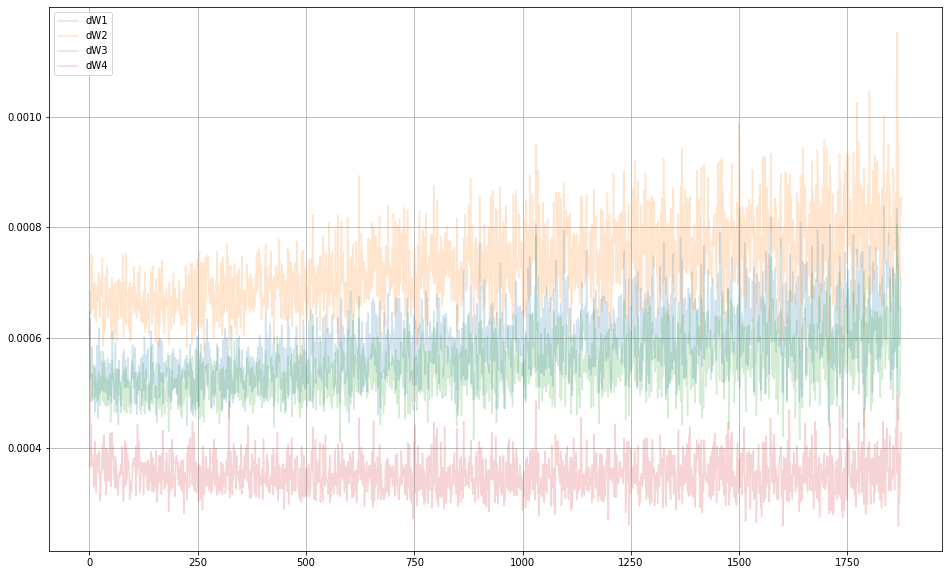

In [10]:
sigmoid_grad_history = []
for grad_epoch in grad_history:
    sigmoid_grad_history.append([np.mean(np.abs(g.numpy())) for g in grad_epoch])
sigmoid_grad_history = np.asarray(sigmoid_grad_history).T

plt.figure(figsize=(16,10))
for i,g in enumerate(sigmoid_grad_history[:-2]): #plot everything but the gradients of output layer
    if i%2==0: # gradients for weights only, not biases
        plt.plot(g,label=label(i),alpha=0.2)
plt.legend(loc='best')
plt.grid('both')
plt.show()

In [11]:
epochs = 1
kernel_initializer = tf.keras.initializers.HeNormal(seed=42)
activation = 'relu'
grad_history = train_model(activation,kernel_initializer,epochs)


Start epoch 0 of 1
Training loss for one batch at step 0: 2.4477598667144775
Training loss for one batch at step 200: 0.6880808472633362
Training loss for one batch at step 400: 0.8295202255249023
Training loss for one batch at step 600: 0.6170855760574341
Training loss for one batch at step 800: 0.6237739324569702
Training loss for one batch at step 1000: 0.5497171878814697
Training loss for one batch at step 1200: 0.41527384519577026
Training loss for one batch at step 1400: 0.3951655924320221
Training loss for one batch at step 1600: 0.8669094443321228
Training loss for one batch at step 1800: 0.41797760128974915


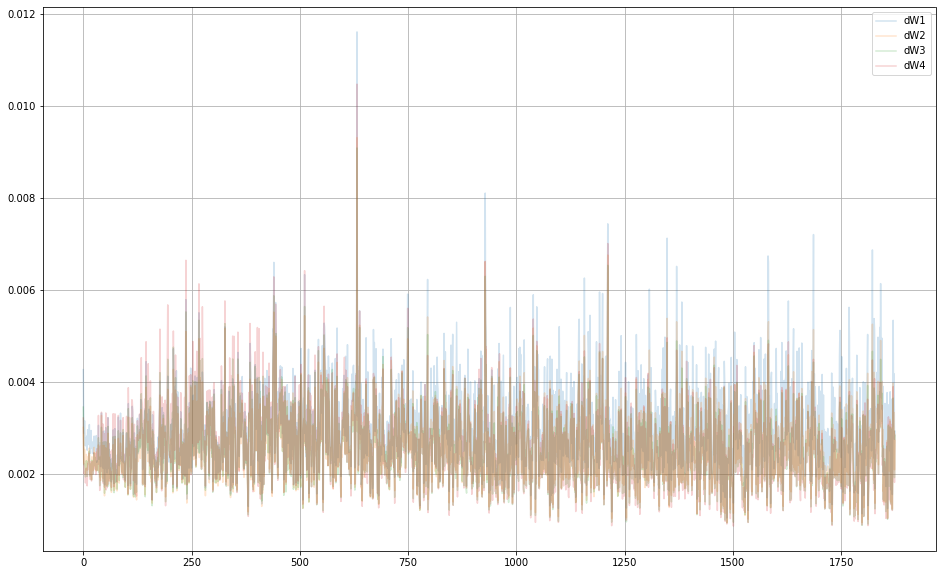

In [12]:
relu_grad_history = []
for grad_epoch in grad_history:
    relu_grad_history.append([np.mean(np.abs(g.numpy())) for g in grad_epoch])
relu_grad_history = np.asarray(relu_grad_history).T

plt.figure(figsize=(16,10))
for i,g in enumerate(relu_grad_history[:-2]):
    if i%2==0:
        plt.plot(g,label=label(i),alpha=0.2)
plt.legend(loc='best')
plt.grid('both')
plt.show()

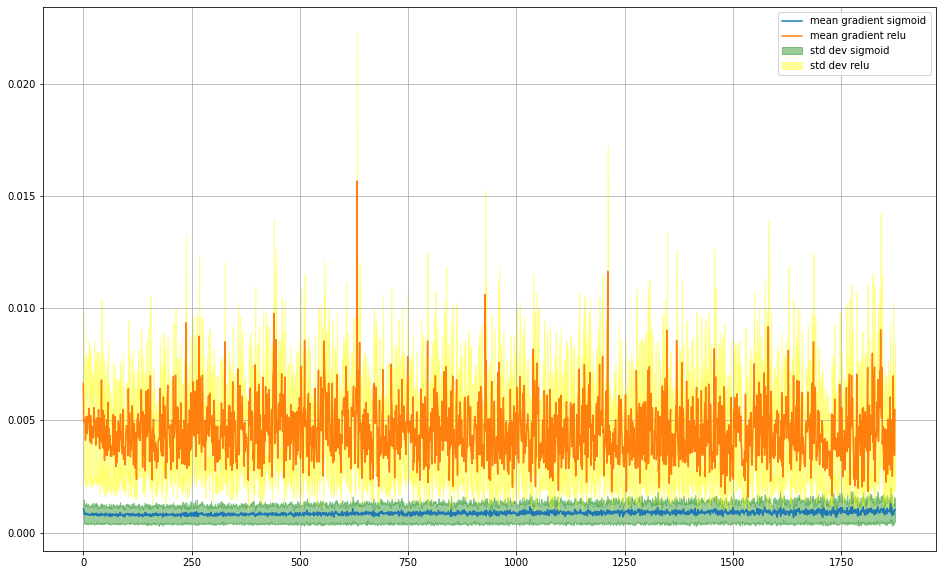

In [13]:
sigmoid_mean_gradients = np.mean(sigmoid_grad_history[:-2],axis=0)
sigmoid_std_gradients = np.std(sigmoid_grad_history[:-2],axis=0)

sigmoid_x_axis = range(len(sigmoid_mean_gradients))
sigmoid_lb = sigmoid_mean_gradients-sigmoid_std_gradients
sigmoid_ub = sigmoid_mean_gradients+sigmoid_std_gradients

relu_mean_gradients = np.mean(relu_grad_history[:-2],axis=0)
relu_std_gradients = np.std(relu_grad_history[:-2],axis=0)

relu_x_axis = range(len(relu_mean_gradients))
relu_lb = relu_mean_gradients-relu_std_gradients
relu_ub = relu_mean_gradients+relu_std_gradients

plt.figure(figsize=(16,10))

plt.plot(sigmoid_mean_gradients,label='mean gradient sigmoid')
plt.fill_between(sigmoid_x_axis,sigmoid_lb,sigmoid_ub,color='green',alpha=0.4,label='std dev sigmoid')

plt.plot(relu_mean_gradients,label='mean gradient relu')
plt.fill_between(relu_x_axis,relu_lb,relu_ub,color='yellow',alpha=0.4,label='std dev relu')
plt.legend(loc='best')
plt.grid('both')
plt.show()

These plots show that the gradients in the relu + He scheme are an order of magnitude higher than in the sigmoid + RandomNormal initialization scheme. We also see that the model trains faster with the relu + He scheme on comparing the evolution of the loss function in each case.